# Lunch Time!
### by Bahar and Lilo

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# import functions from the modsim library
from modsim import *

# import matlab plotting library for graphing
import matplotlib.pyplot as plt

# queue used for lunch line
import queue

## Question

Our central goal is to model each element of getting lunch at Olin. Our question is a predictive one: If one enters the line at a given time, how long must they wait before sitting down with their food?

We have access to the total number of students as well as the overall class schedule. The class schedule tells us approximately how many students are busy or available throughout the lunch period, allowing us to predict their arrivals and departures. Using this model, a student could determine how long they will have to wait before being sitting down and eating lunch on a given weekday.

## Model

Our model of getting lunch at Olin involves three queues. For clarity's sake, our first queue is that for the "Line" and the second for the "Food Court". The "Line" is the line to swipe one's card while the "Food Court" is where one waits to select their meal and then leave to the dining hall to sit down and eat. The third is the holding queue, which serves only to contain all of the people once they have moved through both the Line and Food Court.

To populate the Line queue, we ran an exponentional distribution off of an arrival rate. This arrival rate was defined as the percentage of students available for lunch multipled by the average swipe rate. To find the number of available students, we did a breakdown of the class schedules. Using the number of students available over time created variation in time it takes each student to arrive. As students arrive each minute in our simulation, they are put into the Line.

To determine how to populate the Food Court queue we have a swipe rate. This is how many people can move from the Line to the Food Court per minute. This swipe rate was determined by data we collected at the dining hall and represents a maximum rate. When the dining hall is at its capacity, the Swipe function returns automatically, stopping the influx of students to the Food Court for that minute. We took data to find the value of this capacity. It was determined by observing how many people in the Food Court there were when the rate of students swiping in decreased significantly but there were still students waiting in the Line. The total number of meals served (which in our model equates to the total number of students) is a number we were given by Kevin, the head chef. It is his approximation of how many swipes are recorded each school day during lunch.

Once students are in q2, the "Food Court", they stay there until it is their "turn" to leave. More precisely, the students that have been in the Food Court longest exit q2 each minute. Once a student has left the Food Court, we stop counting their time it took them to get their food.

To develop the model, we first defined our queues, then determined and iterated upon how students move into and out of those queues, adding detail and modifications along the way.

Below are some resources we used to understand and guide our code:

Learning about queues: 
https://dbader.org/blog/queues-in-python

Populating the queue with a for loop: 
https://www.geeksforgeeks.org/stack-queue-python-using-module-queue/

Learning about exponential distribution: 
https://courses.lumenlearning.com/introstats1/chapter/the-exponential-distribution/

To model the lunch hour, we did a breakdown of the class schedule to find when students have time for lunch. Below is this year's class shedule, including only the parts of classes that have start or end times during the lunch period. Also, classes that meet at all of the same times are summed together into one bigger class.

We have created a "person" class, as well as a System defining the total number of students that could have lunch in a given period, the maximum swipes per minute, and the total amount of time during the lunch period in minutes.

Below, we define how the arrival time is calculated and define the aforementioned "person" class. This class alows us to keep track of each person's time going through the Line and Food Court.

We input the class schedule in regular calendar hours and minutes using the Duration class that we have defined for our convenience. It uses an equation to calculate the conversion from hours (ex. 9:05) into minutes since lunch has started, because all of the time calculations within the simulation happen in minutes. Additionally, the results are converted back from minutes into hours in the final result to improve the readability for the user.

In [2]:
class Duration:
    def __init__(self, hour, minute, hour2, minute2):
        self.startTime = (hour - 11.5) * 60 + minute
        self.endTime = (hour2 - 11.5) * 60 + minute2

In [3]:
class Class:
    def __init__(self, students, week):
        self.students = students
        self.week = week

In [4]:
class Person:
    def __init__(self, startTime):
        self.startTime = startTime
        self.swipeTime = 0
        self.exitTime = 0

In [5]:
sys = System(totalStudents=300, swipeRate=10, maxTime=150, maxInCourt=25, exitRate=4, days=5)

In [6]:
def getClasses():
    return [Class(11, {0:Duration(13,30,14,0)}), Class(9, {1:Duration(13,30,14,0)}),
           Class(26, {1:Duration(12,50,14,0)}), Class(6, {2:Duration(13,0,14,0)}),
           Class(86, {2:Duration(13,30,14,0)}),
           Class(123, {0:Duration(13,30,14,0), 3:Duration(13,30,14,0)}),
           Class(267, {0:Duration(11,30,12,30), 3:Duration(11,30,12,30)}),
           Class(24, {4:Duration(13,30,14,0)}), Class(22, {4:Duration(11,30,12,30)}),
           Class(23, {1:Duration(13,30,14,0)}), Class(22, {1:Duration(11,30,12,30)}),
           Class(99, {1:Duration(13,30,14,0), 4:Duration(13,30,14,0)}),
           Class(137, {1:Duration(11,30,12,30), 4:Duration(11,30,12,30)}),
           Class(16, {2:Duration(12,30,14,0), 4:Duration(13,30,14,0)})]

Determining how many students are in class over time:

In [7]:
# Runs class schedule data calculation, summing up number of students in class at a
# given minute of the day based on each class' times and # students enrolled

def calcStudentsBusy(classes):
    # First # is day of the week beginning on Monday, second is minutes since lunch started
    studentsBusy = [[0 for i in range(sys.maxTime)] for j in range(sys.days)]

    # for loop to sum up students in class on a given day at given time
    for c in classes:
        for day in c.week.keys():
            for t in range(len(studentsBusy[day])):
                if t >= c.week[day].startTime and t <= c.week[day].endTime:
                    studentsBusy[day][t] += c.students

    return studentsBusy

The function "calcArrivalTimes" defines how the exponential distribution is run, and ensures that students that have eaten and gone back to class are considered one enitity and not accounted for twice in the model.

In [8]:
# Runs exponential distribution calculations of individuals' arrival times based on # people
# predicted to eat @ dining hall, students in class, and how many have already eaten lunch

def calcArrivalTimes(studentsBusy):
    arrivals = [[0 for i in range(sys.totalStudents)] for j in range(sys.days)]

    for day in range(sys.days):
        arrivalRate = (sys.totalStudents - studentsBusy[day][0]) / sys.totalStudents * sys.swipeRate
        arrivals[day][0] = (np.random.exponential(scale=1.0/arrivalRate))
        becameBusy = 0

        for i in range(1, int(sys.totalStudents)):
            # as students go back to class after eating lunch, there's overlap between students that
            # have eaten and students busy. to fix, we add up diff between prevNumStudentsBusy
            # and currNumStudentsBusy to add back to the numStudentsAvailable
            areBusy = studentsBusy[day][int(arrivals[day][i-1])]
            wereBusy = studentsBusy[day][int(arrivals[day][i-2])]
            becameBusy += max([0, (areBusy - wereBusy)])

            studentsUnavailable = min([areBusy + i - becameBusy, sys.totalStudents])
            arrivalRate = (sys.totalStudents-studentsUnavailable*0.9)/sys.totalStudents*sys.swipeRate

            if arrivalRate > 0:
                timeDiff = np.random.exponential(scale=1.0/arrivalRate)
                arrivals[day][i] = arrivals[day][i-1] + timeDiff

    return arrivals

The code below runs the simulation, updating who is arriving in Line, who gets swiped through to the Food Court, and who exits the system (equivalent to going into q3).

In [9]:
# Runs dining hall line from exponential distribution, finding how many people arrive per minute and adding them to q.
def updateLine(state, arrivals):
    while len(arrivals) > state.lastIndex and arrivals[state.lastIndex] < state.minute + 1:
        state.q.put(Person(int(arrivals[state.lastIndex])))
        state.lastIndex += 1

# If size of q2 reaches that of the maximum Food Court size, then the funtion returns without swiping students through.
def updateSwipe(state):
    for p in range(sys.swipeRate):
        if state.q2.qsize() == sys.maxInCourt:
            return
        if not state.q.empty():
            human = state.q.get()
            human.swipeTime = state.minute
            state.q2.put(human)

# Every minute, 4 people exit the Food Court.
def updateExit(state):
    for p in range(sys.exitRate):
        if not state.q2.empty():
            human = state.q2.get()
            human.exitTime = state.minute
            state.q3.put(human)

In [10]:
# The arrays here append the length of the line at a given time during lunch

def runLineSimulation(arrivals):
    state = State(q=queue.Queue(maxsize=sys.totalStudents), q2=queue.Queue(maxsize=sys.maxInCourt),
              q3=queue.Queue(maxsize=sys.totalStudents), minute=0, lastIndex=0, timeSeries=[])

    for minute in range(int(sys.maxTime)):
        updateLine(state, arrivals)
        updateSwipe(state)
        updateExit(state)
        state.timeSeries.append(state.q.qsize())
        state.minute += 1

    return state.timeSeries, state.q3

In [11]:
def runDaySimulation(arrivals):
    results = [[0 for i in range(sys.maxTime)] for j in range(sys.days)]
    finalQueues = [queue.Queue(maxsize=sys.totalStudents) for i in range(sys.days)]

    for day in range(sys.days):
        results[day], finalQueues[day] = runLineSimulation(arrivals[day])

    return results, finalQueues

Defining how we calculate "timeDiff", aka how long it takes to get lunch.

In [12]:
def determineResults(finalQueues):
    startTimes = [[0 for i in range(sys.totalStudents)] for j in range(sys.days)]
    timeDiffs = [[0 for i in range(sys.totalStudents)] for j in range(sys.days)]

    for day in range(sys.days):
        for i in range(finalQueues[day].qsize()):
            human = finalQueues[day].get()
            startTimes[day][i] = human.startTime
            timeDiffs[day][i] = human.exitTime - human.startTime

    return startTimes, timeDiffs

## Results

Below you can find the graphs that the model creates.

First, a graph from the class schedules documenting the number of people in class on a given day and time. Then, the dining hall arrivals times - note the increase in people arriving at 12:45 - a phenomenon easily verified by the number of times we have waited in line then. Next up, the number of people in that line throughout the lunch period.

You will see that some plots have five lines, and others are five separate plots. We have run the model for each day of the school week, taking into account the different schedules on different days. It may be useful to note that students' Monday and Thursday schdeules are often identical, as are their Tuesday and Friday schedules.

Our final graph plots how long a student waits before getting their food against the time they arrived to the Line. A student or staff member could look at this graph, find what day and time they would like to or are likley to arrive at the Line, and then see the model's prediction for how long they will wait.


Text(0.5, 1.0, 'Class schedule')

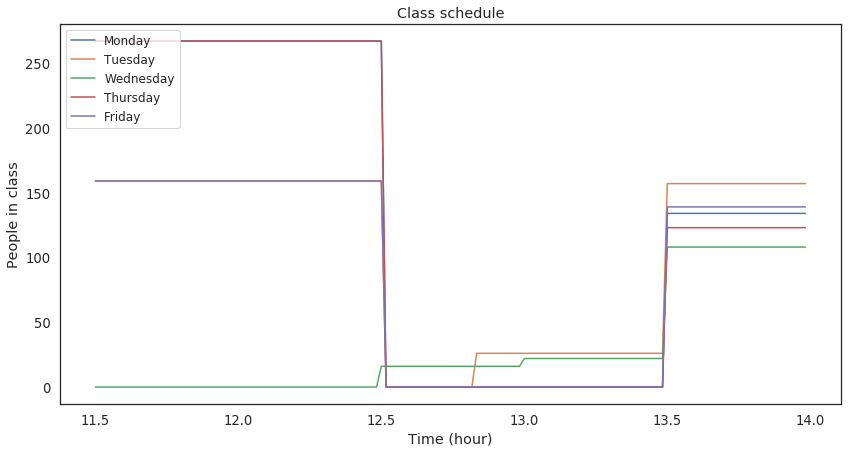

In [13]:
studentsBusy = calcStudentsBusy(getClasses())

nameOfDay = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
time = [11.5 + i/60 for i in range(sys.maxTime)]
plt.figure(figsize=(14,7))

for day in range(sys.days):
    plt.plot(time, studentsBusy[day], label=nameOfDay[day])

plt.legend(loc='upper left', prop={'size': 12})
plt.ylabel('People in class')
plt.xlabel('Time (hour)')
plt.title('Class schedule')

Text(0.5, 1.0, 'Dining hall arrivals')

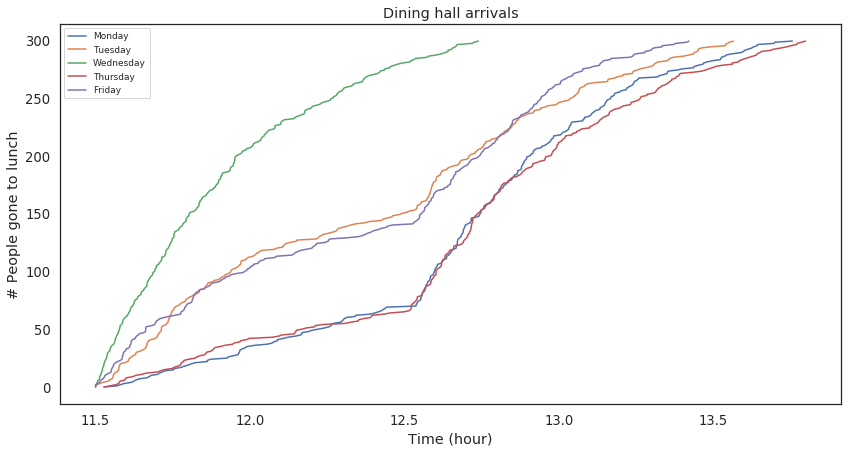

In [14]:
arrivals = calcArrivalTimes(studentsBusy)

plt.figure(figsize=(14,7))
for day in range(sys.days):
    arrivalsInHours = [0 for k in range(len(arrivals[day]))]
    
    for j in range(len(arrivalsInHours)):
        arrivalsInHours[j] = 11.5 + arrivals[day][j]/60.0
        
    plt.plot(arrivalsInHours, [l for l in range(len(arrivalsInHours))], label=nameOfDay[day])
    
plt.legend(loc='upper left', prop={'size': 9})
plt.ylabel('# People gone to lunch')
plt.xlabel('Time (hour)')
plt.title('Dining hall arrivals')

Text(0.5, 1.0, 'Dining hall line length over time')

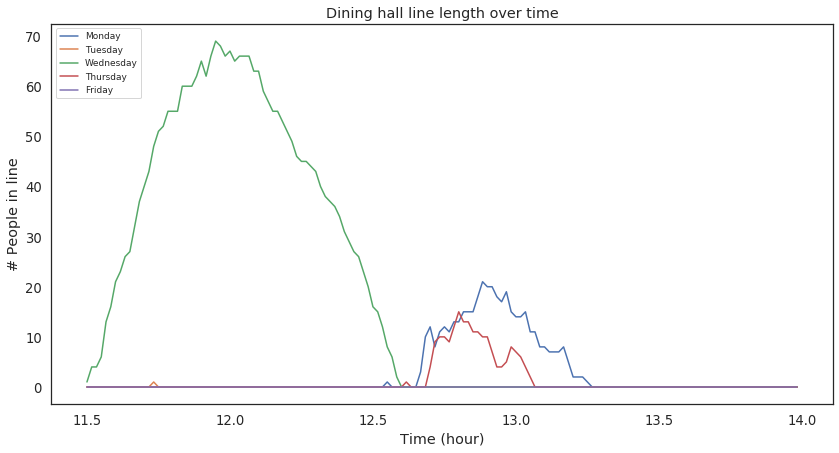

In [15]:
results, finalQueues = runDaySimulation(arrivals)

plt.figure(figsize=(14,7))
for day in range(sys.days):
    plt.plot([11.5+i/60.0 for i in range(len(results[day]))], results[day], label=nameOfDay[day])

plt.legend(loc='upper left', prop={'size': 9})
plt.ylabel('# People in line')
plt.xlabel('Time (hour)')
plt.title('Dining hall line length over time')

Text(0.5, 1.0, 'Wait time by arrival time')

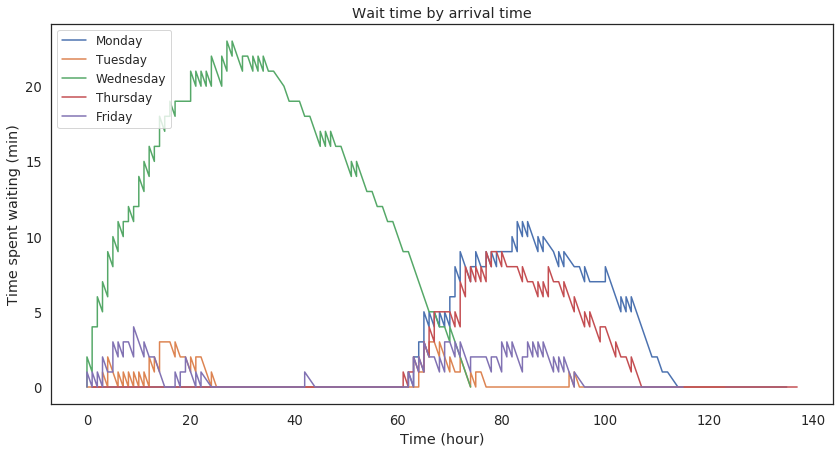

In [16]:
startTimes, timeDiffs = determineResults(finalQueues)

plt.figure(figsize=(14,7))
for day in range(sys.days):
    plt.plot(startTimes[day], timeDiffs[day], label=nameOfDay[day])

plt.legend(loc='upper left', prop={'size': 12})
plt.ylabel('Time spent waiting (min)')
plt.xlabel('Time (hour)')
plt.title('Wait time by arrival time')

## Interpretation

Our graphs currently show trends that seem reasonable compared to our experiences at the dining hall. However, this could be due to the assumptions we have made. Namely, the values for the max swipe rate and exit rate. While the max swipe rate came from data we took over an "average" lunch period (sushi often gathers more attention than sandwhiches but less than burritos), this swipe rate is also connected to our arrival rate in the exponential distribution, and is a maximum. For the purposes of our model using the maximum created reasonable results, however, in most situations with ten (our final maximum swipe rate) people in the Line, the Food Court is too busy to allow all ten people through in a minute. This is a product of Olin being so small that groups of ten are usually during large dining hall rushes.

One of the largest things we are ommitting from the model is Taco Tuesday, and other themed lunch days that affect the number of students that come in. A higher percentage of Olin eats lunch on those days, and Babson students often come by as well. In reality, our program models not the average day at Olin, but the mean day in terms of how busy the whole system is (Line, Food Court, Dining Hall, etc.)

Lastly, Wednesday is the obvious outlier in our results. We think this is because students are less busy on Wednesday mornings due to not having any classes then. Our model tends to be biased towards having people go to lunch almost as soon as they have time available, so on the less busy days such as Wednesday, the predictions it makes may be less correct or useful than the predictions for busier days. Given more time, we would work on adjusting the usage of the exponential distribution function to fix this flaw in our algorithm, but alas, we have run out of time to make the necessary improvements.


While our model may seem reasonable by qualitative means, it is an interesting exercize to compare our model to data from the "real world". Google happens to track how busy restaurants are over time. They do this by using location data from their users ("Google uses aggregated and anonymized data from users who have opted in to Google Location History." https://support.google.com/business/answer/6263531?hl=en). They then present this data when one looks up a restaurant, using a scale of "buness" against time for each day of the week. For some restaurants, Google will also do a live "busyness" tracker to show the current "activity" of the location, occasionally "compared to its usual level of activity." Furthermore, Google is occasionally able to "show how long a customer would have to wait before receiving service during different times of the day, as well as the peak wait time for each day of the week."

We compared our graph for lunch at Olin to the chart Google created for Mantra India (https://mantraindiausa.com/), a popular Indian food restaurant in the middle of downtown Mountain View, Bahar's hometown. Every work day, hundreds, maybe thousands of people working in downtown go out to eat in the surrounding restaurants. We chose Mantra India both for its location as well as for its hours. Similar to our dining hall, Mantra India is only open from 11:30AM–3PM and then 5–10PM every day (similar to Olin but with longer hours). Below is the "busy-ness" chart for Wednesdays:

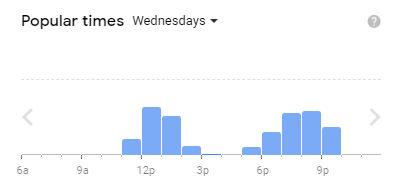

You can see that for a typical Wednesday, Mantra India has a similar curve to that of Olin. While we cannot see the wait times, but one can infer that for low levels of busyness, Mantra India can serve all customers with minimal wait, and then as the lunch rush its between 12pm and 1pm, the business goes up along with the wait time. 

Overall, this real world data confirms that our model at least approximates a lunch rush for an establishment. Hopefully, we can go on to use our model to predict our wait times for getting food, and think fondly back to our first ModSim project.